In [1]:
import numpy as np
import networkx as nx
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import colors
import random
import time
import pickle as pk
import gurobipy as gp
from gurobipy import GRB

This notebook contains a toy example of the HESS model on a synthetic dataset where the map is represented by a perfect rectangle.

In [2]:
def EuclieanDistance(A,B):
    return ((A[0]-B[0])**2 + (A[1]-B[1])**2)**(1/2)

# Input parameters

In [3]:
# number of districts
DISTRICT_NUM = 8
# county width (rectangle width)
ASSIGN_W = 8
# county height (rectangle height)
ASSIGN_H = 8
# population bound
popBound = 0.05



# Generating Data

In [4]:
# creat district set
districtNum = DISTRICT_NUM
district = []

boundRate = popBound
districtSet = []
for idx in range(DISTRICT_NUM):
    district.append("d"+str(idx+1))
    districtSet.append("d"+str(idx+1))
    
# unit names
nodes = []
for idx in range(ASSIGN_W):
    for jdx in range(ASSIGN_H):
        nodes.append("n_x{}_y{}".format(idx,jdx))
        
vertex = nodes
# construct adjacency data
adjList = []
for i in range(ASSIGN_W):
    for j in range(ASSIGN_H):
        # right adj
        if i + 1 < ASSIGN_W:
            adjList.append(["n_x{}_y{}".format(i,j),"n_x{}_y{}".format(i+1,j)])
        # up adj
        if j + 1 < ASSIGN_H:
            adjList.append(["n_x{}_y{}".format(i,j),"n_x{}_y{}".format(i,j+1)])
            
# construct node position
position = {}
population = {}
totalPop = 0
unitNumber = {} #used to count the units in it
for idx in range(ASSIGN_W):
    for jdx in range(ASSIGN_H):
        position["n_x{}_y{}".format(idx,jdx)] = (0.5+1*idx, 0.5+1*jdx)

        population["n_x{}_y{}".format(idx,jdx)] = random.randrange(10,300)
            
        totalPop += population["n_x{}_y{}".format(idx,jdx)]
        unitNumber["n_x{}_y{}".format(idx,jdx)] = 1
        
interval = 2*(totalPop/DISTRICT_NUM)*popBound
pos=position
pop=population
# construct arcs
arcs = []
for a in adjList:
    arcs.append(tuple(a))
    arcs.append((a[1],a[0]))

In [5]:
# prepare some constants for Gurobi model

# population bound
popUpBound = (totalPop/districtNum) * (1 + boundRate)
popLowerBound = (totalPop/districtNum) * (1 - boundRate)

#
w = {}
for v1 in vertex:
    for v2 in vertex:
        w[v1,v2] = EuclieanDistance(pos[v1],pos[v2])

# The Hess Model

In [6]:
m = gp.Model('Hess')

# declare assignment binary variable
x = m.addVars(vertex,vertex, vtype=GRB.BINARY ,name="x")

#objective funciton (maximizing compactness)
obj = gp.quicksum( w[i,j] * x[i,j]  
                    for i in vertex for j in vertex )

m.setObjective(obj,GRB.MINIMIZE)

# add constraints

# Each unit can only be assigned once
m.addConstrs(
    (gp.quicksum(x[i,j] for j in vertex )  == 1 for i in vertex), "onlyOneAssign")

# Choose district centers
m.addConstr(
    (gp.quicksum(x[i,i] for i in vertex )  ==  districtNum), "centerChoice")

# population bounds
m.addConstrs(
    (gp.quicksum( pop[i] * x[i,j] for i in vertex) <=  popUpBound * x[j,j] for j in vertex), "popUp")

m.addConstrs(
    (gp.quicksum( pop[i] * x[i,j] for i in vertex) >=  popLowerBound * x[j,j] for j in vertex), "popLow")

# can only assigned to units that are chosen as district center
m.addConstrs(
    ( x[i,j] <= x[j,j] for i in vertex for j in vertex), "assginLimit")

m.Params.timelimit = 1800.0

m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-05
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4289 rows, 4096 columns and 20416 nonzeros
Model fingerprint: 0xcbb7cfd2
Variable types: 0 continuous, 4096 integer (4096 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Presolve removed 64 rows and 0 columns
Presolve time: 0.04s
Presolved: 4225 rows, 4096 columns, 20416 nonzeros
Variable types: 0 continuous, 4096 integer (4096 binary)
Found heuristic solution: objective 202.2928714

Root relaxation: objective 6.922109e+01, 1268 iterations, 0.04 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex

# Visualization

In [7]:
# read and format the solution
HESSSol = {}
for i in vertex:
    for j in vertex:
        if x[i,j].x >0.5:
                HESSSol[i] = j
                
hess = HESSSol
convertHess = {}
flag = 1
for i in set(hess.values()):
    convertHess[i] = flag
    flag += 1
for key in hess:
    hess[key] = convertHess[hess[key]]
    
assignDict = hess
data_list = []
for i in range(ASSIGN_W):
    temp_list = []
    for j in range(ASSIGN_H):
        temp_list.append(assignDict["n_x{}_y{}".format(i,j)])
    data_list.append(temp_list)

data_list.reverse()

In [8]:
custom_color = []
bounds = []
coloar_patches = []
district_idx = {}
count = 1
for i in districtSet:
    custom_color.append((random.random(),random.random(),random.random()))
    coloar_patches.append(mpatches.Patch(color = custom_color[-1],label = i))
    bounds.append(count)
    district_idx[i] = count
    count += 1

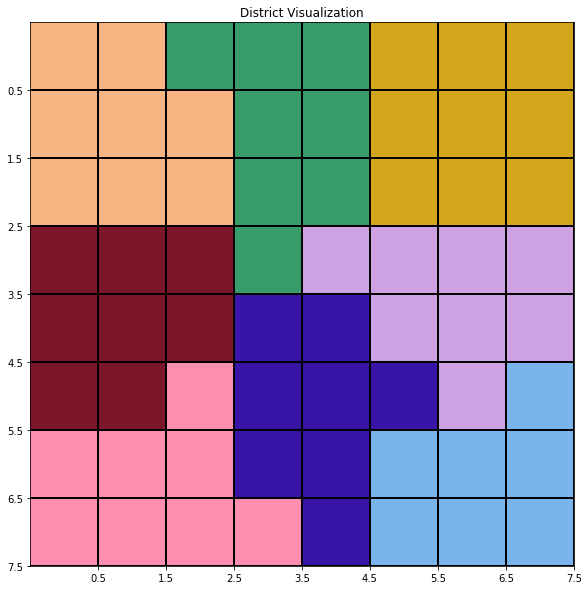

In [9]:
# plotting

# choose color maps
data = data_list
cmap = colors.ListedColormap(custom_color)
norm = colors.BoundaryNorm(bounds, cmap.N)
norm = colors.BoundaryNorm(bounds+[bounds[-1]+1], cmap.N)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(data, cmap=cmap, norm=norm)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, ASSIGN_H+0.5, 1))
ax.set_yticks(np.arange(0.5, ASSIGN_W+0.5, 1))
#ax.set_xticklabels(H)
#ax.set_yticklabels(W)
ax.set_title('District Visualization')
#plt.legend(handles=coloar_patches)
plt.show()